Convolutional Sparse Coding with Mask Decoupling (ADMM)
=======================================================

This example demonstrates the solution of a convolutional sparse coding
problem

  $$\mathrm{argmin}_{\mathbf{x}} \; \frac{1}{2} \Big\| \mathbf{y} -
  B \Big( \sum_k \mathbf{h}_k \ast \mathbf{x}_k \Big) \Big\|_2^2 +
  \lambda \sum_k ( \| \mathbf{x}_k \|_1 - \| \mathbf{x}_k \|_2 ) \;,$$

where the $\mathbf{h}$_k is a set of filters comprising the dictionary,
the $\mathbf{x}$_k is a corrresponding set of coefficient maps,
$\mathbf{y}$ is the signal to be represented, and $B$ is a cropping
operator that allows the boundary artifacts resulting from circular
convolution to be avoided. Following the mask decoupling approach
<cite data-cite="almeida-2013-deconvolving"/>, the problem is posed in ADMM form
as

  $$\mathrm{argmin}_{\mathbf{x}, \mathbf{z}_0, \mathbf{z}_1} \; (1/2) \|
  \mathbf{y} - B \mb{z}_0 \|_2^2 + \lambda \sum_k ( \| \mathbf{z}_{1,k}
  \|_1 - \| \mathbf{z}_{1,k} \|_2 ) \\ \;\; \text{s.t.} \;\;
  \mathbf{z}_0 = \sum_k \mathbf{h}_k \ast \mathbf{x}_k \;\;
  \mathbf{z}_{1,k} = \mathbf{x}_k\;,$$.

The most computationally expensive step in the ADMM algorithm is solved
using the frequency-domain approach proposed in
<cite data-cite="wohlberg-2014-efficient"/>.

In [1]:
import numpy as np

import scico.numpy as snp
from scico import plot
from scico.examples import create_conv_sparse_phantom
from scico.functional import L1MinusL2Norm, ZeroFunctional
from scico.linop import CircularConvolve, Crop, Identity, Sum
from scico.loss import SquaredL2Loss
from scico.optimize.admm import ADMM, G0BlockCircularConvolveSolver
from scico.util import device_info
plot.config_notebook_plotting()

Set problem size and create random convolutional dictionary (a set of
filters) and a corresponding sparse random set of coefficient maps.

In [2]:
N = 121  # image size
Nnz = 128  # number of non-zeros in coefficient maps
h, x0 = create_conv_sparse_phantom(N, Nnz)

Normalize dictionary filters and scale coefficient maps accordingly.

In [3]:
hnorm = np.sqrt(np.sum(h**2, axis=(1, 2), keepdims=True))
h /= hnorm
x0 *= hnorm

Convert numpy arrays to jax arrays.

In [4]:
h = snp.array(h)
x0 = snp.array(x0)

Set up required padding and corresponding crop operator.

In [5]:
h_center = (h.shape[1] // 2, h.shape[2] // 2)
pad_width = ((0, 0), (h_center[0], h_center[0]), (h_center[1], h_center[1]))
x0p = snp.pad(x0, pad_width=pad_width)
B = Crop(pad_width[1:], input_shape=x0p.shape[1:])

Set up sum-of-convolutions forward operator.

In [6]:
C = CircularConvolve(h, input_shape=x0p.shape, ndims=2, h_center=h_center)
S = Sum(input_shape=C.output_shape, axis=0)
A = S @ C

Construct test image from dictionary $\mathbf{h}$ and padded version of
coefficient maps $\mathbf{x}_0$.

In [7]:
y = B(A(x0p))

Set functional and solver parameters.

In [8]:
λ = 1e0  # ℓ1-ℓ2 norm regularization parameter
ρ0 = 1e0  # ADMM penalty parameters
ρ1 = 3e0
maxiter = 200  # number of ADMM iterations

Define loss function and regularization. Note the use of the
$\ell_1 - \ell_2$ norm, which has been found to provide slightly better
performance than the $\ell_1$ norm in this type of problem
<cite data-cite="wohlberg-2021-psf"/>.

In [9]:
f = ZeroFunctional()
g0 = SquaredL2Loss(y=y, A=B)
g1 = λ * L1MinusL2Norm()
C0 = A
C1 = Identity(input_shape=x0p.shape)

Initialize ADMM solver.

In [10]:
solver = ADMM(
    f=f,
    g_list=[g0, g1],
    C_list=[C0, C1],
    rho_list=[ρ0, ρ1],
    alpha=1.8,
    maxiter=maxiter,
    subproblem_solver=G0BlockCircularConvolveSolver(check_solve=True),
    itstat_options={"display": True, "period": 10},
)

Run the solver.

In [11]:
print(f"Solving on {device_info()}\n")
x1 = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  Slv Res  
----------------------------------------------------------
   0  5.39e+00  1.836e+04  1.916e+02  2.736e+03  0.000e+00


  10  6.69e+00  3.178e+03  6.317e+00  3.707e+01  8.155e-06


  20  6.94e+00  2.910e+03  2.659e+00  1.704e+01  6.000e-06


  30  7.18e+00  2.813e+03  1.857e+00  1.497e+01  5.030e-06


  40  7.42e+00  2.747e+03  1.477e+00  7.858e+00  1.021e-05


  50  7.65e+00  2.707e+03  1.221e+00  8.315e+00  9.221e-06


  60  7.91e+00  2.676e+03  1.069e+00  8.148e+00  3.720e-06


  70  8.19e+00  2.649e+03  9.735e-01  5.134e+00  7.928e-06


  80  8.46e+00  2.627e+03  9.067e-01  4.546e+00  7.015e-06


  90  8.73e+00  2.608e+03  8.481e-01  5.035e+00  4.892e-06


 100  9.03e+00  2.589e+03  8.027e-01  4.251e+00  7.820e-06


 110  9.25e+00  2.574e+03  7.622e-01  3.253e+00  5.158e-06


 120  9.49e+00  2.559e+03  7.252e-01  3.339e+00  1.054e-05


 130  9.72e+00  2.546e+03  6.984e-01  3.336e+00  6.485e-06


 140  9.94e+00  2.533e+03  6.744e-01  2.810e+00  6.168e-06


 150  1.03e+01  2.521e+03  6.523e-01  2.624e+00  1.127e-05


 160  1.05e+01  2.510e+03  6.312e-01  2.685e+00  9.606e-06


 170  1.08e+01  2.500e+03  6.088e-01  2.498e+00  5.920e-06


 180  1.10e+01  2.490e+03  5.847e-01  2.295e+00  1.340e-05


 190  1.13e+01  2.481e+03  5.612e-01  2.237e+00  1.296e-05


 199  1.15e+01  2.474e+03  5.380e-01  2.157e+00  7.942e-06


Show the recovered coefficient maps.

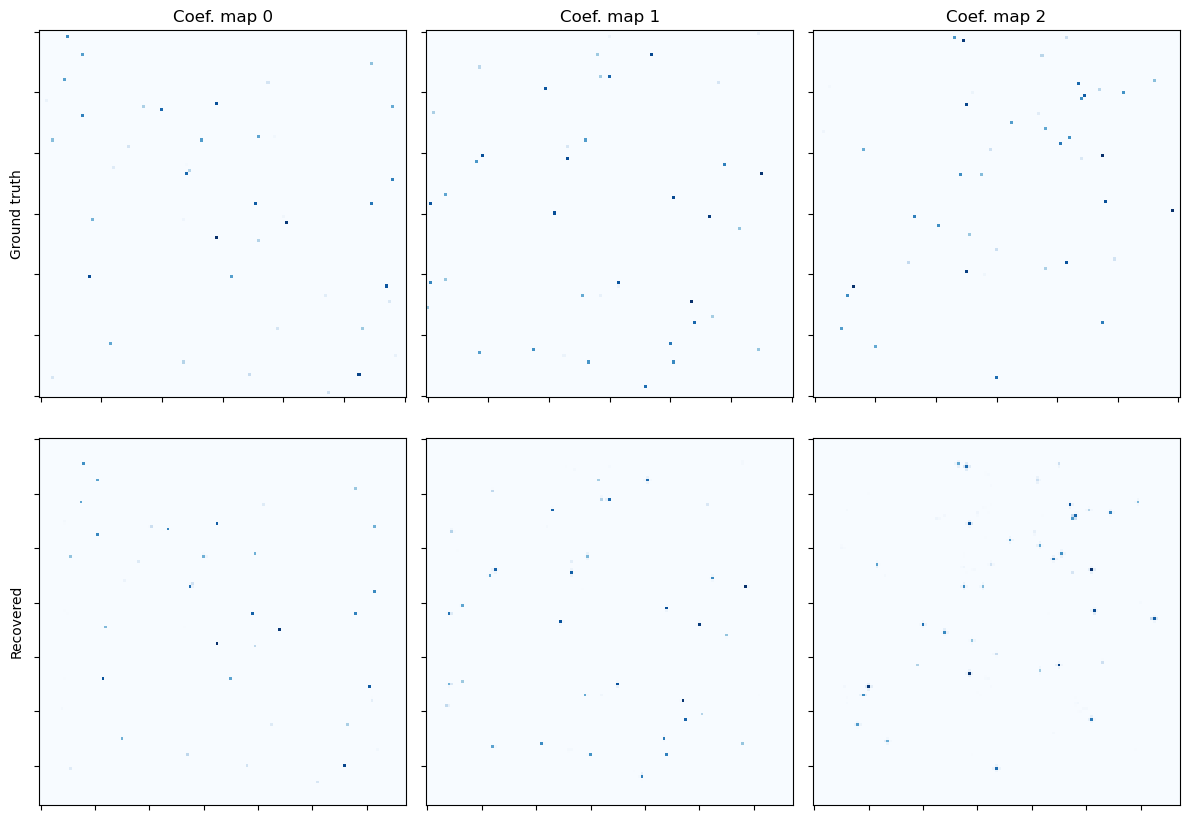

In [12]:
fig, ax = plot.subplots(nrows=2, ncols=3, figsize=(12, 8.6))
plot.imview(x0[0], title="Coef. map 0", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 0])
ax[0, 0].set_ylabel("Ground truth")
plot.imview(x0[1], title="Coef. map 1", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 1])
plot.imview(x0[2], title="Coef. map 2", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 2])
plot.imview(x1[0], cmap=plot.cm.Blues, fig=fig, ax=ax[1, 0])
ax[1, 0].set_ylabel("Recovered")
plot.imview(x1[1], cmap=plot.cm.Blues, fig=fig, ax=ax[1, 1])
plot.imview(x1[2], cmap=plot.cm.Blues, fig=fig, ax=ax[1, 2])
fig.tight_layout()
fig.show()

Show test image and reconstruction from recovered coefficient maps. Note
the absence of the wrap-around effects at the boundary that can be seen
in the corresponding images in the [related example](sparsecode_conv_admm.rst).

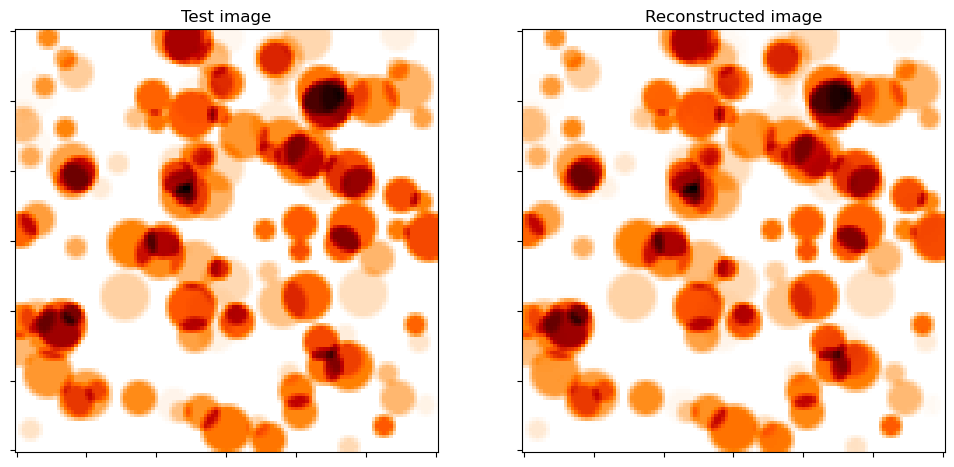

In [13]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 6))
plot.imview(y, title="Test image", cmap=plot.cm.gist_heat_r, fig=fig, ax=ax[0])
plot.imview(B(A(x1)), title="Reconstructed image", cmap=plot.cm.gist_heat_r, fig=fig, ax=ax[1])
fig.show()

Plot convergence statistics.

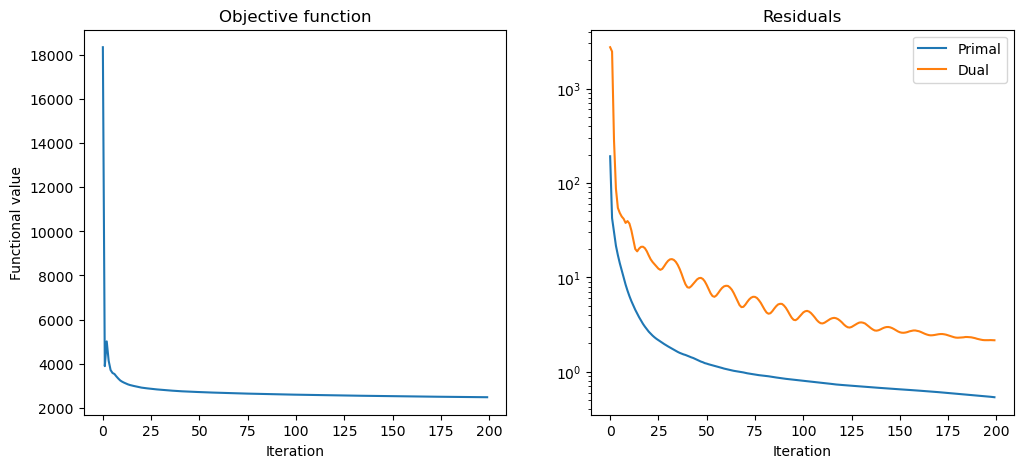

In [14]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()